In [53]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import pacf,acf
from statsmodels.graphics import tsaplots
import matplotlib.pyplot as plt
from arch import arch_model
from scipy import stats
from statsmodels.tools.eval_measures import rmse

In [2]:
sns.set()
wd=os.getcwd()
wd

'C:\\Users\\iavta\\Time Series'

In [3]:
path_clean_data=wd+r"\Data - Clean"

# data was cleaned in a previous notebook
df=pd.read_csv(path_clean_data+r"\EUStock_TimeIndex.csv",parse_dates=True,index_col=0)


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1860 entries, 1991-07-01 to 1998-08-14
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DAX     1860 non-null   float64
 1   SMI     1860 non-null   float64
 2   CAC     1860 non-null   float64
 3   FTSE    1860 non-null   float64
dtypes: float64(4)
memory usage: 72.7 KB


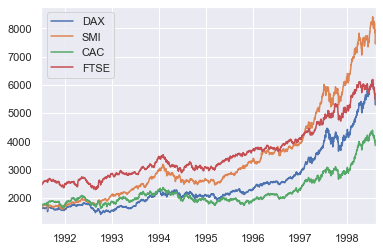

In [5]:
df.plot();

In a previous notebook, we saw how we could remove the increasing variability by applying a Cox-Box, or a log transformation. In this notebook, we'll take a different approach.

Usually, for the pricing of an asset, we're interested in modeling the return or growth rate of a series.

In [42]:
df_pctchange=df.pct_change()*100

In [43]:
# from sklearn.model_selection import TimeSeriesSplit
# train_test_index=TimeSeriesSplit(n_splits=2,test_size=1,gap=0)
# list(train_test_index.split(df))

In [44]:
train_data=df_pctchange.iloc[:-100]
test_data=df_pctchange.iloc[-100:]

In [45]:
train_data.shape, test_data.shape

((1760, 4), (100, 4))

In [46]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1760 entries, 1991-07-01 to 1998-03-27
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DAX     1759 non-null   float64
 1   SMI     1759 non-null   float64
 2   CAC     1759 non-null   float64
 3   FTSE    1759 non-null   float64
dtypes: float64(4)
memory usage: 68.8 KB


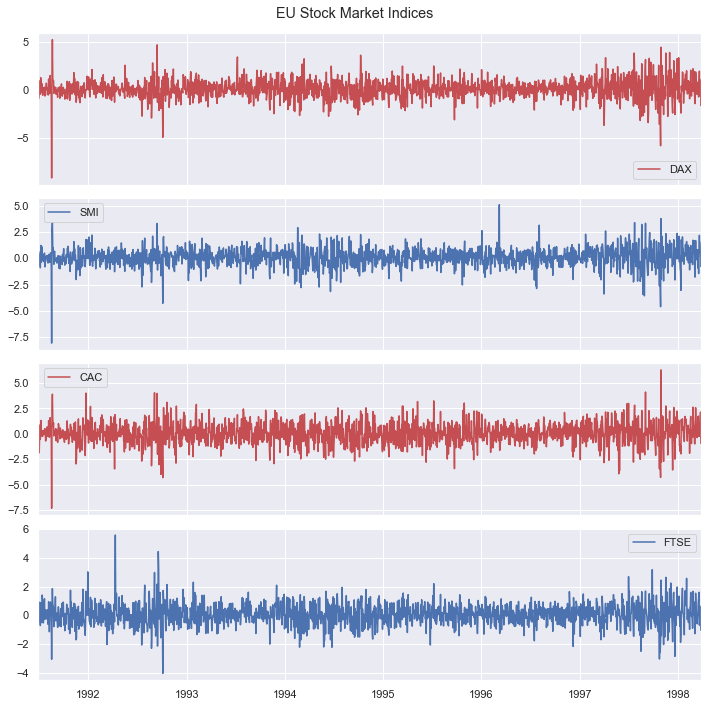

In [47]:
train_data.plot(kind='line', subplots=True, title="EU Stock Market Indices",
        layout=(4, 1), sharex=True, sharey=False, legend=True,    
        style=['r', 'b', 'r', 'b'], figsize=(10,10))
plt.tight_layout()
plt.show;

In finance, for many assets pricing problems we're interested in the volatility/variability of a time series. ARMA models were used to model the conditional mean of a process when the conditional variance was constant. However, this assumption may be violated in many contexts. The graphs above seem to suggest one of those cases. The plots seem to be white noise, mean zero, with occasional concentrated bursts of variability.

Note: An ARCH model could be used for any series that has periods of increased or decreased variance, not only for percent changes. We could fit an ARCH model to the residuals after an ARIMA model has already been fitted to the data.

In [48]:
train_data_sq=train_data.apply(lambda x: x**2).dropna()

Looking at the squared data, when it's already in a white-noise form with mean zero, is a simple way to check for the variability bursts.

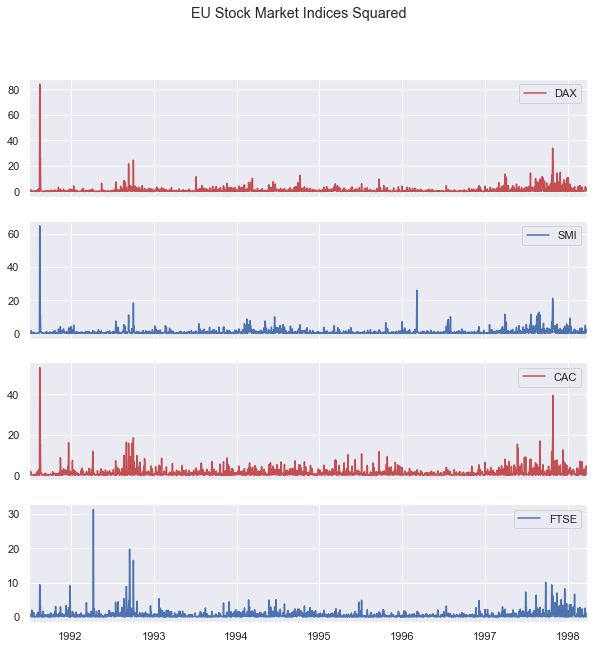

In [49]:
train_data_sq.plot(kind='line', subplots=True, title="EU Stock Market Indices Squared",
        layout=(4, 1), sharex=True, sharey=False, legend=True,    
        style=['r', 'b', 'r', 'b'], figsize=(10,10));

We can use the ACF and PACF plots to estimate values for p and q, in a similar way as is done for the ARMA model.

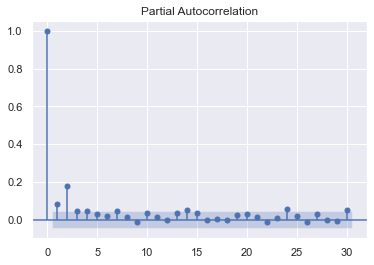

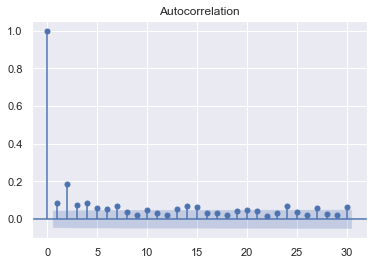

In [51]:
mkt_ind="DAX"
tsaplots.plot_pacf(train_data_sq[mkt_ind],lags=30);
tsaplots.plot_acf(train_data_sq[mkt_ind],lags=30);

Let's try a GARCH(1,1) model, since the above looks like an ARMA plot.

In [98]:
# define model
model_garch = arch_model(train_data[mkt_ind].dropna(), vol='GARCH',
                        p=1, o=0, q=1,dist="StudentsT")
model_garch = model_garch.fit(disp="off");

In [99]:
model_garch.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Constant Mean - GARCH Model Results                         
====================================================================================
Dep. Variable:                          DAX   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -2323.59
Distribution:      Standardized Student's t   AIC:                           4657.19
Method:                  Maximum Likelihood   BIC:                           4684.55
                                              No. Observations:                 1759
Date:                      Tue, Nov 30 2021   Df Residuals:                     1758
Time:                              12:58:18   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0749  1.882e-02      3.978  6.948e-05 [3.797e-02,  0.112]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0208  1.015e-02      2.053  4.009e-02 [9.426e-04,4.073e-02]
alpha[1]       0.0717  1.745e-02      4.105  4.037e-05   [3.744e-02,  0.106]
beta[1]        0.9095  2.393e-02     37.999      0.000     [  0.863,  0.956]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             5.8957      1.012      5.827  5.656e-09 [  3.913,  7.879]
========================================================================

Covariance estimator: robust
"""

In [148]:
# for analytical forecasts - in-sample
# forecasts2 = model_garch.forecast(start=1750,horizon=1, #test_data[mkt_ind].shape[0],
#                                   reindex=False)
# forecasts2.variance.plot()

In [114]:
# for simulated forecasts - out-of-sample
forecasts = model_garch.forecast(horizon=test_data[mkt_ind].shape[0],
                                   method='simulation', simulations=1,
                                   reindex=False)

In [115]:
predictions=forecasts.simulations
predictions.values.shape

(1, 1, 100)

In [116]:
y=predictions.values.ravel()
x=test_data[mkt_ind].index

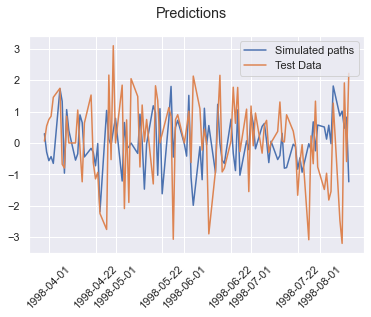

In [176]:
#train_data[mkt_ind][-100:].plot(figsize = (12, 5), legend = True)
#test_data[mkt_ind].plot(legend=True)
lines1 = plt.plot(x,y)
lines1[0].set_label('Simulated paths')
lines2 = plt.plot(x,test_data[mkt_ind])
lines2[0].set_label('Test Data')
plt.tick_params(axis="x", labelrotation=45)
plt.suptitle("Predictions")
plt.legend()
plt.show;

TODO:
+ Check residuals with LJB test
+ VaR analysis
+ Other GARCH type models, like 